# General Consideration

When we're talking about fitting data with a given model(linear model), 
we are actually dealing with solving a linear equation
\begin{equation}
    Y = A\, X
\end{equation}
in which 
\begin{align}
    Y =& 
     \begin{bmatrix}
        y_1 \\ 
        y_2 \\
        \vdots \\
        y_N
     \end{bmatrix} \\
    A =& 
     \begin{bmatrix}
        1& x_1 \\ 
        1& x_2 \\
        \vdots \\
        1& x_N
     \end{bmatrix} \\
    X =& 
     \begin{bmatrix}
         b \\ 
         m
     \end{bmatrix}
\end{align}
We cannot solve the above equation directly, because it's over-constrained.
On way to solve this is to multiply matrices to reduce dimensionality.  
From another perspective, what we are doing is to find two parameters, 
namely $b, m$ to minimize an objective function called $\chi^2$,
which is the total squared error, scaled by uncertainties, or 
\begin{equation}
\chi^2 =\sum_{i=1}^N \frac{[y_i - f(x_i)]^2}{\sigma_{y_i}^2}\equiv[Y-AX]^{\intercal}C^{-1}[Y-AX]
\end{equation}
$\chi^2$ can be regarded as a metric distance between fitted points and raw data in data space. 
And $\sigma_{y_i}$ is the corresponding weight of each point. 
When $\sigma_{y_i}$ is large, $\chi^2$ becomes less "sensitive" about $[y_i - f(x_i)]^2$, 
which affects the importance of $y_i$ to final result. 

# Perfect x, Gaussian y

When x data is accurate without error, the uncentainty(not error) of y data is 
Gaussian uncentainty. Introduce the covariance matrix $C$
\begin{equation}
    C = \begin{bmatrix}
        \sigma_{y_{11}}& \sigma_{y_{12}}& \cdots& \sigma_{y_{1N}}\\
        \sigma_{y_{21}}& \sigma_{y_{22}}& \cdots& \sigma_{y_{2N}}\\
        \vdots& \vdots& \vdots& \vdots\\
        \sigma_{y_{N1}}& \sigma_{y_{N2}}& \cdots& \sigma_{y_{NN}}\\
    \end{bmatrix}
\end{equation}
According to $\chi^2$'s definition, the best-fit parameters can be abtained by
\begin{equation}
    \begin{bmatrix}
        b \\
        m
    \end{bmatrix}
    = [A^{\intercal}C^{-1}A]^{-1}[A^{\intercal}C^{-1}Y]
\end{equation}

In [6]:
# %load cp_imports.py
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Use retina backend for better figures
%config InlineBackend.figure_format = 'retina'



In [94]:
df = pd.read_csv("data/Hogg_2010_ex1.csv", index_col=0, header=0)
print(df.head(n=10))

      x    y  sigma_y  sigma_x  rho_xy
ID                                    
1   201  592       61        9   -0.84
2   244  401       25        4    0.31
3    47  583       38       11    0.64
4   287  402       15        7   -0.27
5   203  495       21        5   -0.33
6    58  173       15        9    0.67
7   210  479       27        4   -0.02
8   202  504       14        4   -0.05
9   198  510       30       11   -0.84
10  158  416       16        7   -0.69


[34.04772776] [2.23992083]
[[ 3.32922601e+02 -1.88954491e+00]
 [-1.88954491e+00  1.16166311e-02]]
[ 2.23992083 34.04772776]


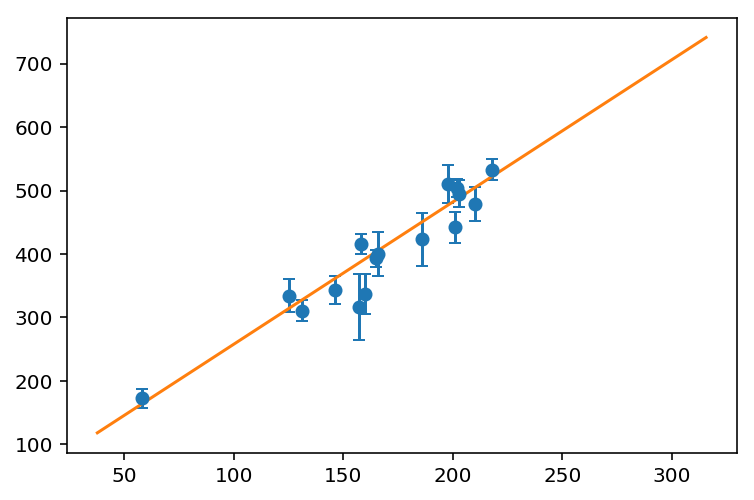

In [129]:
def fit_Gaussian(x, y, sigma_y):
    '''
    x: x data, 1-D ndarray of size N 
    y: y data, 1-D ndarray of size N
    sigma_y: covariance matrix of y, 2-D array of shape (N, N)
    
    return best-fit slope and intersect with their uncertainties 
    '''
    # Set x, y to column vector
    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))

    # Construct needed matrics
    A = np.concatenate((np.ones_like(x), x), axis=1)
    
    _left = np.matmul(np.matmul(A.T, sigma_y.I), A).I
    _right = np.matmul(np.matmul(A.T, sigma_y.I), y)
    b, m = np.array(np.matmul(_left, _right))
    fit_cov = np.array(_left)
    return b, m, fit_cov


x = np.linspace(0.8 * min(df.x), 1.1 * max(df.x))
sigma_y = np.diag(df.sigma_y[4:])

# Set number of data points to be ignored 
start = 4
# Convert Series to ndarray for shape manipulation
raw_x = np.matrix(df.x[start:])
raw_y = np.matrix(df.y[start:])
# Note for the square of sigma_y
sigma_y = np.matrix(np.diag(df.sigma_y[start:]**2))
# Ignore the first four data points
b, m, covs = fit_Gaussian(raw_x, raw_y, sigma_y)


plt.errorbar(df.x[start:], df.y[start:], yerr=df.sigma_y[start:], 
             marker="o", capsize=3, linestyle=" ")
plt.plot(x, m * x + b)
print(b, m)
print(covs)

p = np.polyfit(df.x[start:], df.y[start:], 1, w=1/df.sigma_y[start:])
print(p)

[[7.28946265e+01]
 [1.59605045e+00]
 [2.29888841e-03]]
[[ 1.51410913e+03 -2.14671957e+01  6.99004580e-02]
 [-2.14671957e+01  3.36107642e-01 -1.15856956e-03]
 [ 6.99004580e-02 -1.15856956e-03  4.13658125e-06]]


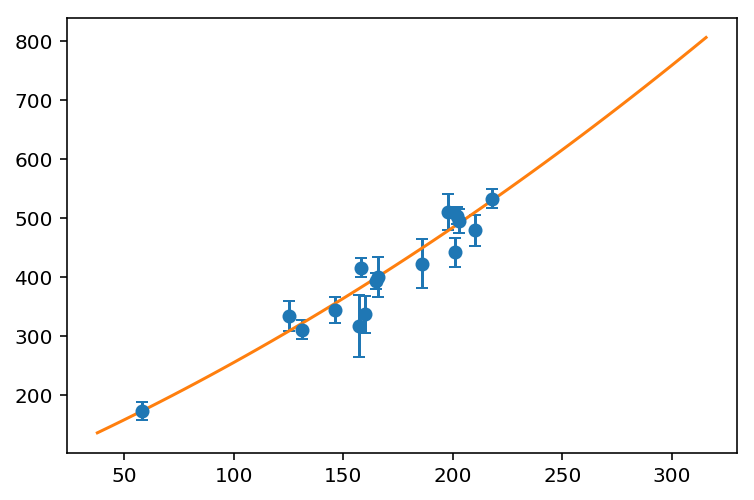

In [145]:
def fit_n_Gaussian(x, y, sigma_y, order=1):
    '''
    x: x data, 1-D ndarray of size N 
    y: y data, 1-D ndarray of size N
    sigma_y: covariance matrix of y, 2-D array of shape (N, N)
    
    return best-fit slope and intersect with their uncertainties 
    '''
    # Set x, y to column vector
    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))

    # Construct needed matrics
    A = np.concatenate((np.ones_like(x), x), axis=1)
    
    for i in range(2, order+1):
        A = np.concatenate((A, np.array(x)**i), axis=1)
    
    _left = np.matmul(np.matmul(A.T, sigma_y.I), A).I
    _right = np.matmul(np.matmul(A.T, sigma_y.I), y)
    coes = np.array(np.matmul(_left, _right))
    fit_cov = np.array(_left)
    return coes, fit_cov


x = np.linspace(0.8 * min(df.x), 1.1 * max(df.x))
sigma_y = np.diag(df.sigma_y[4:])

# Set number of data points to be ignored 
start = 4
# Convert Series to ndarray for shape manipulation
raw_x = np.matrix(df.x[start:])
raw_y = np.matrix(df.y[start:])
# Note for the square of sigma_y
sigma_y = np.matrix(np.diag(df.sigma_y[start:]**2))
# Ignore the first four data points
coes, covs = fit_n_Gaussian(raw_x, raw_y, sigma_y, order=2)


plt.errorbar(df.x[start:], df.y[start:], yerr=df.sigma_y[start:], 
             marker="o", capsize=3, linestyle=" ")
plt.plot(x, coes[0] + coes[1] * x + coes[2] * x**2)
print(coes)
print(covs)

In [140]:
for i in range(2, 1):
    print(i)

In [134]:
y

matrix([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [41]:
np.linalg.inv()

array([0, 1, 2, 3])

In [138]:
whos

Variable       Type         Data/Info
-------------------------------------
a              matrix       [[0 1 2 3]]
b              ndarray      1: 1 elems, type `float64`, 8 bytes
berr           ndarray      2: 2 elems, type `float64`, 16 bytes
c              ndarray      4: 4 elems, type `int32`, 16 bytes
covs           ndarray      2x2: 4 elems, type `float64`, 32 bytes
d              ndarray      4: 4 elems, type `int32`, 16 bytes
df             DataFrame          x    y  sigma_y  si<...>      22        5   -0.56
fit_Gaussian   function     <function fit_Gaussian at 0x0000025D0E905D90>
m              ndarray      1: 1 elems, type `float64`, 8 bytes
merr           ndarray      2: 2 elems, type `float64`, 16 bytes
np             module       <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
p              ndarray      2: 2 elems, type `float64`, 16 bytes
pd             module       <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt            module       <module 'matpl

a